In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io
import requests
from sklearn import metrics
from sklearn.utils import resample

In [2]:
mpl.rcParams['figure.figsize'] = (12,10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
non_suspect_df = pd.read_csv("RYM_LAST3M_NON_SUSPECTS.csv")
suspect_df = pd.read_csv("RYM_ALL_SUSPECTS.csv")
n_minority = int(len(non_suspect_df)*1)
suspect_df = resample(
    suspect_df, replace=True, n_samples = n_minority, random_state=42
)

C:\Users\aphan\AppData\Local\Temp\ipykernel_9832\1574996104.py:2: DtypeWarning: Columns (28,38) have mixed types. Specify dtype option on import or set low_memory=False.
  non_suspect_df = pd.read_csv("RYM_LAST3M_NON_SUSPECTS.csv")
C:\Users\aphan\AppData\Local\Temp\ipykernel_9832\1574996104.py:3: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  suspect_df = pd.read_csv("RYM_ALL_SUSPECTS.csv")


In [4]:
#suspect_test_df = pd.read_csv("suspects list.csv")
non_suspect_df['Carton Weight'] = pd.to_numeric(non_suspect_df['Carton Weight'], errors = 'coerce')
suspect_df['Carton Weight'] = pd.to_numeric(suspect_df['Carton Weight'], errors='coerce')
non_suspect_df = non_suspect_df.dropna(subset=['Carton Weight'])
suspect_df = suspect_df.dropna(subset=['Carton Weight'])

In [5]:
non_suspect_df['suspect_flag'] = 0
suspect_df['suspect_flag'] = 1
df = pd.concat([non_suspect_df, suspect_df], ignore_index = True)
df = df.drop(['Suspect Reason', 'Lead Edge Orientation','SKU', 'SKU Description','CaseGroupNumber', 'Customer Carton Ref', 'Level', 'Aisle', 'AisleSide', 'Bay', 'Shelf Height', 'Seg Zone', 'Pick Label Type', 'Label Type', 'ShelfLocation OffsetY', 'ShelfLocation Width', 'Entering Warehouse Time', 'ODV', 'ODV Length', 'ODV Width', 'ODV Height', 'ODV Weight', 'SKU CreatedDate', 'Is Suspect', 'Suspect Action', 'Suspect Time', 'License Plate Number', 'On Shelf Time', 'Stored Time', 'Outer Length', 'Outer Width', 'Outer Height', 'Lead Edge Length', 'Idvid', 'IDV Length', 'IDV Width', 'IDV Height', 'IDV Weight', 'Inbound Cell', 'Bot Measured Length', 'Bot Measured Width', 'Last Bot Number', 'Last Task Plan ID', 'Report Date', 'LASTORDERDATE'], axis=1)
df

,Shelf,Carton Length,Carton Width,Carton Height,Carton Weight,suspect_flag
0,1,367,300,254,14805,0
1,1,367,300,254,14805,0
2,1,364,304,255,14806,0
3,2,365,298,255,14804,0
4,2,365,298,255,14804,0
...,...,...,...,...,...,...
5999995,1,257,182,236,868,1
5999996,1,448,277,101,1623,1
5999997,1,345,209,94,5477,1
5999998,1,343,241,91,4545,1


In [6]:
# Feature engineering
#Volume
df['Volume'] = df['Carton Length']*df['Carton Width']*df['Carton Height']
#Weight/Volume Ratio
df['weight_to_volume'] = df['Carton Weight']/df['Volume']
#Dimension Ratios
df['length_to_width'] = df['Carton Length']/df['Carton Width']
df['length_to_height'] = df['Carton Length']/df['Carton Height']
df['width_to_height'] = df['Carton Width']/df['Carton Height']


df['length_squared'] = df['Carton Length']**2
df['width_squared'] = df['Carton Width']**2
df['height_squared'] = df['Carton Height']**2


df['dimension_std'] = df[['Carton Length', 'Carton Width', 'Carton Height']].std(axis=1)

df['base_area_to_height'] = (df['Carton Length']*df['Carton Width'])/df['Carton Height']

df['log_weight'] = np.log(df['Carton Weight']+1)

df['cubed_length'] = df['Carton Length']**3
df['cubed_width'] = df['Carton Width']**3
df['cubed_height'] = df['Carton Height']**3


df['cube_root_volume'] = df['Volume']**(1/3)

df['square_root_volume'] = df['Volume']**(1/2)

df['weight*volume'] = df['Carton Weight']*df['Volume']

df['weight*length'] = df['Carton Weight']*df['Carton Length']

df['length/(width+height)'] = df['Carton Length'] / (df['Carton Width'] + df['Carton Height'])
df['width/(length+height)'] = df['Carton Width'] / (df['Carton Length'] + df['Carton Height'])
df['height/(length+width)'] = df['Carton Height'] / (df['Carton Length'] + df['Carton Width'])


df['weight/volume'] = df['Carton Weight']/df['Volume']

df['weight**2/volume'] = (df['Carton Weight']**2)/df['Volume']

# Surface Area
df['Surface_Area'] = 2 * (
    df['Carton Length'] * df['Carton Width'] +
    df['Carton Length'] * df['Carton Height'] +
    df['Carton Width'] * df['Carton Height']
)

# Diagonal Length
df['Diagonal'] = np.sqrt(
    df['Carton Length']**2 + df['Carton Width']**2 + df['Carton Height']**2
)

# Dimension Comparison Features

# Max, Min, and Range of Dimensions
df['max_dimension'] = df[['Carton Length', 'Carton Width', 'Carton Height']].max(axis=1)
df['min_dimension'] = df[['Carton Length', 'Carton Width', 'Carton Height']].min(axis=1)
df['dimension_range'] = df['max_dimension'] - df['min_dimension']

# Fractions of Dimensions
df['total_dimension'] = df['Carton Length'] + df['Carton Width'] + df['Carton Height']
df['length_fraction'] = df['Carton Length'] / df['total_dimension']
df['width_fraction'] = df['Carton Width'] / df['total_dimension']
df['height_fraction'] = df['Carton Height'] / df['total_dimension']


# Composite & Interaction Features
df['weight_times_total_dimension'] = df['Carton Weight'] * df['total_dimension']

# Differences Between Dimensions
df['diff_length_width'] = abs(df['Carton Length'] - df['Carton Width'])
df['diff_length_height'] = abs(df['Carton Length'] - df['Carton Height'])
df['diff_width_height'] = abs(df['Carton Width'] - df['Carton Height'])


# Efficiency Metrics
df['SA_to_Volume'] = df['Surface_Area'] / (df['Volume'] + 1e-8)  # add epsilon to avoid division by 0

# Log transformations of composite features
df['log_Surface_Area'] = np.log(df['Surface_Area']+1)

df['log_SA_to_Volume'] = np.log(df['SA_to_Volume']+1)



In [7]:
# Feature engineering
#Volume
test_df = pd.read_csv('test_snapshot_10M.csv')
test_df['suspect_flag'] = (test_df['Is Suspect']=='Yes').astype(int)

test_df['Volume'] = test_df['Carton Length']*test_df['Carton Width']*test_df['Carton Height']
#Weight/Volume Ratio
test_df['weight_to_volume'] = test_df['Carton Weight']/test_df['Volume']
#Dimension Ratios
test_df['length_to_width'] = test_df['Carton Length']/test_df['Carton Width']
test_df['length_to_height'] = test_df['Carton Length']/test_df['Carton Height']
test_df['width_to_height'] = test_df['Carton Width']/test_df['Carton Height']


test_df['length_squared'] = test_df['Carton Length']**2
test_df['width_squared'] = test_df['Carton Width']**2
test_df['height_squared'] = test_df['Carton Height']**2


test_df['dimension_std'] = test_df[['Carton Length', 'Carton Width', 'Carton Height']].std(axis=1)

test_df['base_area_to_height'] = (test_df['Carton Length']*test_df['Carton Width'])/test_df['Carton Height']

test_df['log_weight'] = np.log(test_df['Carton Weight']+1)

test_df['cubed_length'] = test_df['Carton Length']**3
test_df['cubed_width'] = test_df['Carton Width']**3
test_df['cubed_height'] = test_df['Carton Height']**3


test_df['cube_root_volume'] = test_df['Volume']**(1/3)

test_df['square_root_volume'] = test_df['Volume']**(1/2)

test_df['weight*volume'] = test_df['Carton Weight']*test_df['Volume']

test_df['weight*length'] = test_df['Carton Weight']*test_df['Carton Length']

test_df['length/(width+height)'] = test_df['Carton Length'] / (test_df['Carton Width'] + test_df['Carton Height'])
test_df['width/(length+height)'] = test_df['Carton Width'] / (test_df['Carton Length'] + test_df['Carton Height'])
test_df['height/(length+width)'] = test_df['Carton Height'] / (test_df['Carton Length'] + test_df['Carton Width'])


test_df['weight/volume'] = test_df['Carton Weight']/test_df['Volume']

test_df['weight**2/volume'] = (test_df['Carton Weight']**2)/test_df['Volume']

# Surface Area
test_df['Surface_Area'] = 2 * (
    test_df['Carton Length'] * test_df['Carton Width'] +
    test_df['Carton Length'] * test_df['Carton Height'] +
    test_df['Carton Width'] * test_df['Carton Height']
)

# Diagonal Length
test_df['Diagonal'] = np.sqrt(
    test_df['Carton Length']**2 + test_df['Carton Width']**2 + test_df['Carton Height']**2
)

# Dimension Comparison Features

# Max, Min, and Range of Dimensions
test_df['max_dimension'] = test_df[['Carton Length', 'Carton Width', 'Carton Height']].max(axis=1)
test_df['min_dimension'] = test_df[['Carton Length', 'Carton Width', 'Carton Height']].min(axis=1)
test_df['dimension_range'] = test_df['max_dimension'] - test_df['min_dimension']

# Fractions of Dimensions
test_df['total_dimension'] = test_df['Carton Length'] + test_df['Carton Width'] + test_df['Carton Height']
test_df['length_fraction'] = test_df['Carton Length'] / test_df['total_dimension']
test_df['width_fraction'] = test_df['Carton Width'] / test_df['total_dimension']
test_df['height_fraction'] = test_df['Carton Height'] / test_df['total_dimension']


# Composite & Interaction Features
test_df['weight_times_total_dimension'] = test_df['Carton Weight'] * test_df['total_dimension']

# Differences Between Dimensions
test_df['diff_length_width'] = abs(test_df['Carton Length'] - test_df['Carton Width'])
test_df['diff_length_height'] = abs(test_df['Carton Length'] - test_df['Carton Height'])
test_df['diff_width_height'] = abs(test_df['Carton Width'] - test_df['Carton Height'])


# Efficiency Metrics
test_df['SA_to_Volume'] = test_df['Surface_Area'] / (test_df['Volume'] + 1e-8)  # add epsilon to avoid division by 0

# Log transformations of composite features
test_df['log_Surface_Area'] = np.log(test_df['Surface_Area']+1)

test_df['log_SA_to_Volume'] = np.log(test_df['SA_to_Volume']+1)



C:\Users\aphan\AppData\Local\Temp\ipykernel_9832\2362248321.py:3: DtypeWarning: Columns (0,28,29,30,38) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('test_snapshot_10M.csv')


In [8]:
neg, pos = np.bincount(df['suspect_flag'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 6000000
    Positive: 3000000 (50.00% of total)



In [9]:
from sklearn.preprocessing import LabelEncoder

train_df, val_df = train_test_split(df, test_size=0.2, random_state = 75)

train_labels = np.array(train_df.pop('suspect_flag')).reshape(-1,1)
bool_train_labels = train_labels[:,0] != 0
val_labels = np.array(val_df.pop('suspect_flag')).reshape(-1,1)
test_labels = np.array(test_df.pop('suspect_flag')).reshape(-1,1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

sanitized_categorical_cols = []
column_name_mapping = {}

for col in categorical_cols:
    # Replace spaces and other invalid characters with underscores
    sanitized_name = col.replace(' ', '_').replace('-', '_')
    sanitized_categorical_cols.append(sanitized_name)
    column_name_mapping[sanitized_name] = col

# 2. Rename columns in your dataframes
for old_name, new_name in zip(categorical_cols, sanitized_categorical_cols):
    train_df = train_df.rename(columns={old_name: new_name})
    val_df = val_df.rename(columns={old_name: new_name})
    test_df = test_df.rename(columns={old_name: new_name})

# Update categorical_cols to use sanitized names
categorical_cols = sanitized_categorical_cols

numerical_cols = [col for col in train_df.columns if col not in categorical_cols]

label_encoders = {}
train_categorical_inputs = []
val_categorical_inputs = []
test_categorical_inputs = []

for col in categorical_cols:
    # Create and fit label encoder for each categorical column
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))
    label_encoders[col] = le
    
    # Transform each dataset with the encoder
    train_encoded = le.transform(train_df[col].astype(str)).reshape(-1, 1)
    val_encoded = le.transform(val_df[col].astype(str)).reshape(-1, 1)
    test_encoded = le.transform(test_df[col].astype(str)).reshape(-1, 1)
    
    # Store encoded values for model input
    train_categorical_inputs.append(train_encoded)
    val_categorical_inputs.append(val_encoded)
    test_categorical_inputs.append(test_encoded)

train_numerical = train_df[numerical_cols].values if numerical_cols else None
val_numerical = val_df[numerical_cols].values if numerical_cols else None
test_numerical = test_df[numerical_cols].values if numerical_cols else None

if numerical_cols:
    scaler = StandardScaler()
    train_numerical = scaler.fit_transform(train_numerical)
    val_numerical = scaler.transform(val_numerical)
    test_numerical = scaler.transform(test_numerical)

    from joblib import dump
    dump(scaler, 'standard_scaler.bin')
    dump(label_encoders, 'label_encoders.bin')

Categorical columns: []


In [10]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')


Average class probability in training set:   0.4998
Average class probability in validation set: 0.5008
Average class probability in test set:       0.0005


In [11]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    categorical_feature_inputs = []
    embedding_outputs = []

    for i, col in enumerate(categorical_cols):
        # Get number of unique categories
        num_categories = len(label_encoders[col].classes_)
        
        # Calculate appropriate embedding dimension
        # Rule of thumb: min(50, num_categories/2) with minimum of 2
        embedding_dim = min(50, num_categories // 2)
        embedding_dim = max(2, embedding_dim)
        
        # Create input layer for this categorical feature
        input_layer = keras.Input(shape=(1,), name=f'{col}_input')
        categorical_feature_inputs.append(input_layer)
        
        # Create embedding layer
        embedding = keras.layers.Embedding(
            input_dim=num_categories,
            output_dim=embedding_dim,
            input_length=1,
            name=f'{col}_embedding'
        )(input_layer)
    
   # Flatten the embedding
        flattened = keras.layers.Flatten(name=f'{col}_flatten')(embedding)
        embedding_outputs.append(flattened)
    
    # Add numerical features if they exist
    if numerical_cols:
        numerical_input = keras.Input(shape=(len(numerical_cols),), name='numerical_input')
        categorical_feature_inputs.append(numerical_input)
        embedding_outputs.append(numerical_input)
    
    # Combine all features
    if len(embedding_outputs) > 1:
        combined = keras.layers.Concatenate()(embedding_outputs)
    else:
        combined = embedding_outputs[0]
    
    # Continue with the dense layers as in your original model
    x = keras.layers.Dense(128, activation='relu')(combined)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    output = keras.layers.Dense(1, activation='sigmoid', 
                                bias_initializer=output_bias)(x)
    
    # Create model with multiple inputs
    model = keras.Model(inputs=categorical_feature_inputs, outputs=output)
    
    # Compile with the same configuration as your original model
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True),
        metrics=metrics)
    
    return model

In [12]:
def prepare_model_inputs():
    # Combine categorical inputs
    train_inputs = train_categorical_inputs.copy()
    val_inputs = val_categorical_inputs.copy()
    test_inputs = test_categorical_inputs.copy()
    
    # Add numerical features if they exist
    if train_numerical is not None:
        train_inputs.append(train_numerical)
        val_inputs.append(val_numerical)
        test_inputs.append(test_numerical)
    
    return train_inputs, val_inputs, test_inputs

# Get inputs ready for model
train_inputs, val_inputs, test_inputs = prepare_model_inputs()

EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)         │ (None, 44)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           5,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [14]:
prediction_inputs = [x[:10] for x in train_inputs]
predictions = model.predict(prediction_inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


In [15]:
results = model.evaluate(train_inputs, train_labels, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Brier score: 0.2551 - accuracy: 0.5123 - auc: 0.5298 - cross entropy: 0.7057 - fn: 921990.2500 - fp: 249814.6094 - loss: 0.0831 - prc: 0.5231 - precision: 0.5275 - recall: 0.2323 - tn: 952051.6875 - tp: 278446.1562
Loss: 0.0831


In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([0.])

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(prediction_inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[0.4206636 ],
       [0.3677917 ],
       [0.51056194],
       [0.47464842],
       [0.4420613 ],
       [0.4208402 ],
       [0.5511718 ],
       [0.5066804 ],
       [0.55992866],
       [0.453924  ]], dtype=float32)

In [18]:
results = model.evaluate(train_inputs, train_labels, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - Brier score: 0.2579 - accuracy: 0.4914 - auc: 0.4906 - cross entropy: 0.7110 - fn: 2626876.0000 - fp: 1049325.7500 - loss: 0.0928 - prc: 0.5004 - precision: 0.4855 - recall: 0.2672 - tn: 2553470.5000 - tp: 972630.3750
Loss: 0.0927


In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_inputs,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_inputs, val_labels),
    verbose=1)

Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - Brier score: 0.2498 - accuracy: 0.5117 - auc: 0.5386 - cross entropy: 0.6922 - fn: 4166777.2500 - fp: 1669114.3750 - loss: 0.0607 - prc: 0.5531 - precision: 0.5207 - recall: 0.3044 - tn: 4334452.0000 - tp: 1831959.1250 - val_Brier score: 0.2008 - val_accuracy: 0.6579 - val_auc: 0.8290 - val_cross entropy: 0.5815 - val_fn: 393455.0000 - val_fp: 17011.0000 - val_loss: 0.0536 - val_prc: 0.8409 - val_precision: 0.9242 - val_recall: 0.3453 - val_tn: 582059.0000 - val_tp: 207475.0000
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - Brier score: 0.1989 - accuracy: 0.6727 - auc: 0.8211 - cross entropy: 0.5777 - fn: 726622.8125 - fp: 58409.4844 - loss: 0.0544 - prc: 0.8320 - precision: 0.8897 - recall: 0.3943 - tn: 1143110.6250 - tp: 474159.8125 - val_Brier score: 0.1979 - val_accuracy: 0.6608 - val_auc: 0.8359 - val_cross entropy: 0.5750 - val_fn: 390407.0000 - val_fp: 16677.0000 - val_loss: 0.0527 - val_prc: 0.8476 - val_precisio

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_inputs,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_inputs, val_labels),
    verbose=1)

Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Brier score: 0.2010 - accuracy: 0.6713 - auc: 0.8196 - cross entropy: 0.5833 - fn: 1103430.5000 - fp: 87616.3281 - loss: 0.0607 - prc: 0.8301 - precision: 0.8907 - recall: 0.3910 - tn: 1712526.2500 - tp: 698729.6875 - val_Brier score: 0.1995 - val_accuracy: 0.6636 - val_auc: 0.8294 - val_cross entropy: 0.5791 - val_fn: 383235.0000 - val_fp: 20473.0000 - val_loss: 0.0535 - val_prc: 0.8401 - val_precision: 0.9140 - val_recall: 0.3623 - val_tn: 578597.0000 - val_tp: 217695.0000
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - Brier score: 0.1991 - accuracy: 0.6711 - auc: 0.8206 - cross entropy: 0.5782 - fn: 730719.0000 - fp: 57916.6328 - loss: 0.0544 - prc: 0.8311 - precision: 0.8897 - recall: 0.3902 - tn: 1143665.7500 - tp: 470001.2812 - val_Brier score: 0.2002 - val_accuracy: 0.6548 - val_auc: 0.8358 - val_cross entropy: 0.5797 - val_fn: 399632.0000 - val_fp: 14662.0000 - val_loss: 0.0529 - val_prc: 0.8473 - val_precision:

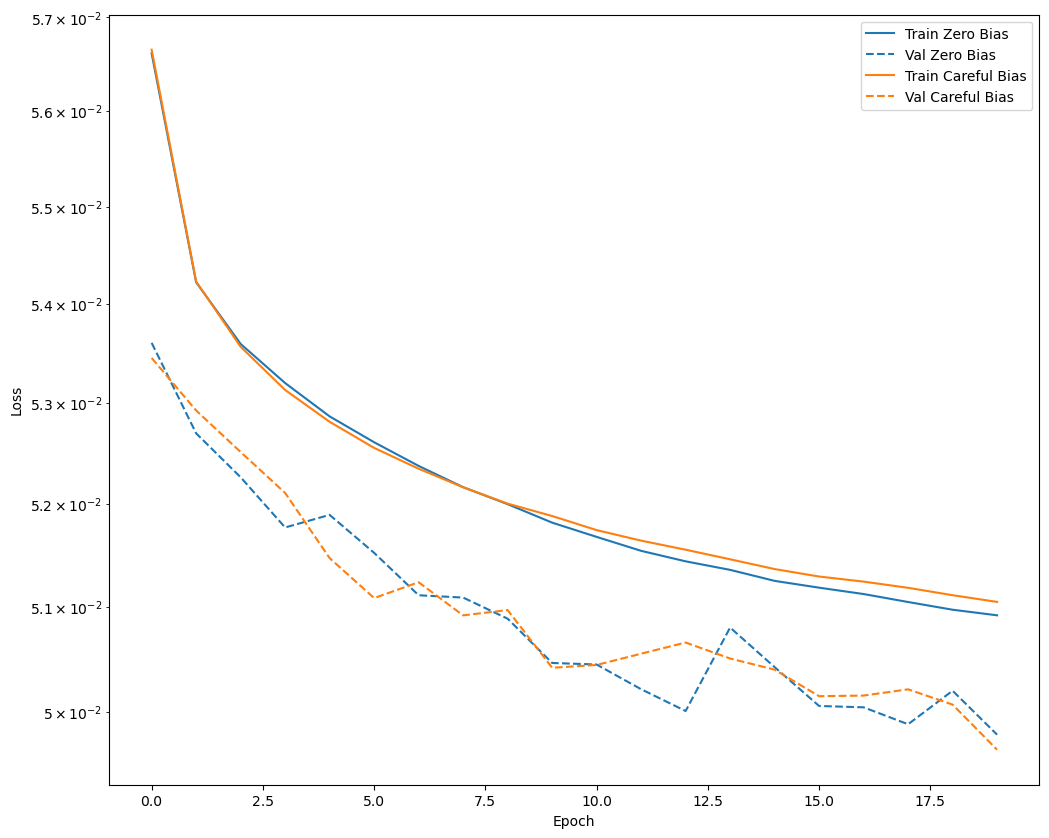

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [23]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_inputs,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_inputs, val_labels))

Epoch 1/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - Brier score: 0.2010 - accuracy: 0.6711 - auc: 0.8195 - cross entropy: 0.5831 - fn: 1100461.3750 - fp: 91666.0312 - loss: 0.0608 - prc: 0.8292 - precision: 0.8858 - recall: 0.3929 - tn: 1709208.1250 - tp: 700967.1250 - val_Brier score: 0.2034 - val_accuracy: 0.6431 - val_auc: 0.8299 - val_cross entropy: 0.5872 - val_fn: 417104.0000 - val_fp: 11206.0000 - val_loss: 0.0538 - val_prc: 0.8417 - val_precision: 0.9425 - val_recall: 0.3059 - val_tn: 587864.0000 - val_tp: 183826.0000
Epoch 2/100
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - Brier score: 0.1996 - accuracy: 0.6708 - auc: 0.8199 - cross entropy: 0.5792 - fn: 730560.3125 - fp: 58210.6328 - loss: 0.0546 - prc: 0.8303 - precision: 0.8893 - recall: 0.3901 - tn: 1143347.3750 - tp: 470184.4062 - val_Brier score: 0.2004 - val_accuracy: 0.6506 - val_auc: 0.8356 - val_cross entropy: 0.5804 - val_fn: 406422.0000 - val_fp: 12884.0000 - val_loss: 0.0530 - val_prc: 0.8471 - val_precisio

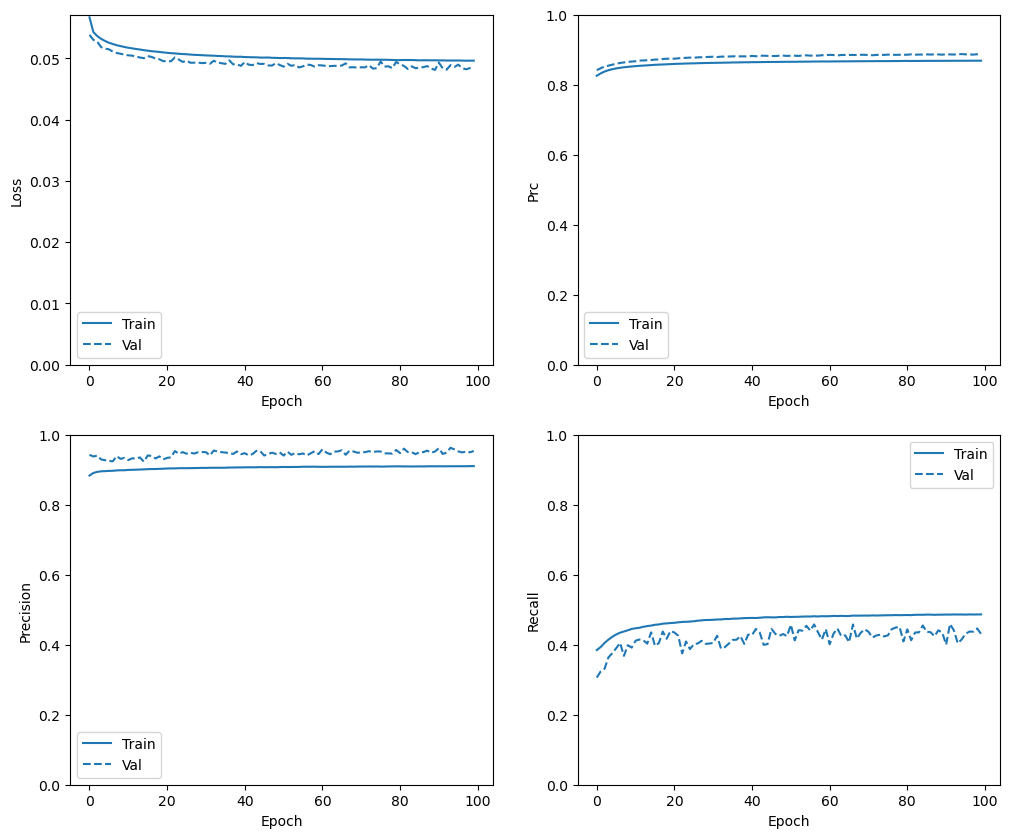

In [24]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(baseline_history)

In [25]:
train_predictions_baseline = model.predict(train_inputs, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_inputs, batch_size=BATCH_SIZE)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
4883/4883 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


loss :  0.048147860914468765
compile_metrics :  0.43255218863487244

Legitimate Transactions Detected (True Negatives):  9638074
Legitimate Transactions Incorrectly Detected (False Positives):  357242
Fraudulent Transactions Missed (False Negatives):  3010
Fraudulent Transactions Detected (True Positives):  1674
Total Fraudulent Transactions:  4684


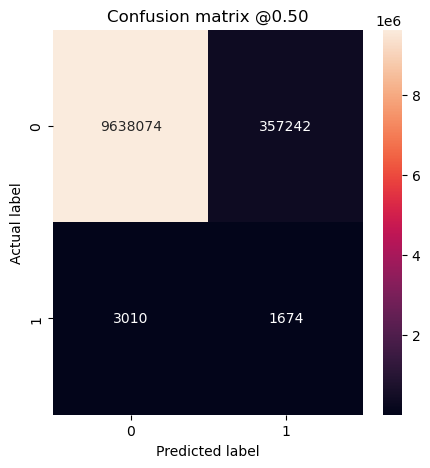

In [26]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))
baseline_results = model.evaluate(test_inputs, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [27]:
print(keras.__version__)
print(tf.__version__)

3.9.2
2.19.0


In [28]:
model.save('neural_net_model.h5')

In [29]:
#pd_scaler = StandardScaler().fit(train_numerical)

In [30]:
#dump(pd_scaler, 'standard_scaler.bin')

In [31]:
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)         │ (None, 44)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           5,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,932 (113.02 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 14,339 (56.02 KB)

None
